# SVTR OCR – Notebook Standalone


## Path setup and imports

In [14]:
import os
import io
import csv
import re
import random
from pathlib import Path
from datetime import datetime
from difflib import SequenceMatcher

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageFilter, ImageEnhance
from torch.utils.data import Dataset, DataLoader

ROOT = Path('.').resolve()
if not (ROOT / 'configs').exists():
    ROOT = ROOT / 'My_Project' / 'task2_svtr_v1'
ROOT = ROOT.resolve()

# ICDAR data (adjust if needed)
ICDAR_DATA = ROOT.parent.parent / 'ICDAR-2019-SROIE' / 'data'
if not ICDAR_DATA.exists():
    ICDAR_DATA = ROOT.parent / 'ICDAR-2019-SROIE' / 'data'

# Data directory: prefer task2_upgrade_v2 (same as .py pipeline)
BASE = ROOT.parent / 'task2_upgrade_v2'
if (BASE / 'data_train').exists():
    DATA_TRAIN, DATA_VALID, DATA_TEST = BASE/'data_train', BASE/'data_valid', BASE/'data_test'
    LMDB_TRAIN, LMDB_VAL = BASE/'dataset'/'train', BASE/'dataset'/'val'
    print('Using data + LMDB from task2_upgrade_v2')
else:
    DATA_TRAIN, DATA_VALID, DATA_TEST = ROOT/'data_train', ROOT/'data_valid', ROOT/'data_test'
    LMDB_TRAIN, LMDB_VAL = ROOT/'dataset'/'train', ROOT/'dataset'/'val'
EXPR = ROOT / 'expr'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('ROOT:', ROOT)
print('Device:', device)
print('ICDAR_DATA:', ICDAR_DATA, '(exists:', ICDAR_DATA.exists(), ')')

Using data + LMDB from task2_upgrade_v2
ROOT: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1
Device: cuda
ICDAR_DATA: C:\Users\AD\Downloads\ComputerVision\Project_Final\ICDAR-2019-SROIE\data (exists: True )


---
## Step 1: Data preparation (ICDAR → data_train / data_valid / data_test)

In [15]:
def parse_box_line(line):
    if not isinstance(line, list) or len(line) < 8:
        return None, ""
    try:
        coords = [int(float(x.strip())) for x in line[:8]]
        xs = [coords[0], coords[2], coords[4], coords[6]]
        ys = [coords[1], coords[3], coords[5], coords[7]]
        xmin, xmax = max(0, min(xs)), max(xs)
        ymin, ymax = max(0, min(ys)), max(ys)
        if xmax <= xmin or ymax <= ymin:
            return None, ""
        text = ",".join(line[8:]).strip() if len(line) > 8 else ""
        return (xmin, ymin, xmax, ymax), text
    except (ValueError, IndexError):
        return None, ""

def prepare_icdar_data(icdar_path, train_dir, val_dir, test_dir, val_ratio=0.15, test_ratio=0.15, seed=42):
    img_dir = icdar_path / 'img'
    box_dir = icdar_path / 'box'
    if not img_dir.is_dir() or not box_dir.is_dir():
        print('ICDAR img/box not found:', icdar_path)
        return False
    box_files = list(box_dir.glob('*.csv')) + list(box_dir.glob('*.txt'))
    ids = sorted(set(f.stem for f in box_files))
    random.seed(seed)
    random.shuffle(ids)
    n_test = max(0, int(len(ids) * test_ratio))
    rest = ids[n_test:]
    n_val = max(1, int(len(rest) * val_ratio)) if rest else 0
    test_ids, val_ids = set(ids[:n_test]), set(rest[:n_val])
    train_ids = set(rest[n_val:])
    for d in [train_dir, val_dir, test_dir]:
        d.mkdir(parents=True, exist_ok=True)
    ct, cv, cte = 0, 0, 0
    for id_ in ids:
        img_path = img_dir / f'{id_}.jpg'
        if not img_path.exists():
            img_path = img_dir / f'{id_}.png'
        if not img_path.exists():
            continue
        box_path = box_dir / f'{id_}.csv'
        if not box_path.exists():
            box_path = box_dir / f'{id_}.txt'
        if not box_path.exists():
            continue
        try:
            with open(box_path, 'r', encoding='utf-8') as f:
                rows = list(csv.reader(f))
        except Exception:
            continue
        try:
            im = Image.open(img_path).convert('L')
        except Exception:
            continue
        out_dir = test_dir if id_ in test_ids else (val_dir if id_ in val_ids else train_dir)
        for i, row in enumerate(rows):
            if not row:
                continue
            rect, text = parse_box_line(row)
            if rect is None:
                continue
            try:
                crop = im.crop(rect)
            except Exception:
                continue
            base = f'{id_}_{i}'
            crop.save(out_dir / f'{base}.jpg')
            label = text.replace('\n', ' ').replace('\\', ' ').strip()
            (out_dir / f'{base}.txt').write_text(label, encoding='utf-8')
            if id_ in test_ids:
                cte += 1
            elif id_ in val_ids:
                cv += 1
            else:
                ct += 1
    print('Train:', ct, 'Val:', cv, 'Test:', cte)
    return True

# Skip if already using task2_upgrade_v2 (cell 1)
if (BASE / 'data_train').exists():
    print('Using data from task2_upgrade_v2 (cell 1)')
elif ICDAR_DATA.exists():
    prepare_icdar_data(ICDAR_DATA, DATA_TRAIN, DATA_VALID, DATA_TEST)
elif not (BASE / 'data_train').exists() and not DATA_TRAIN.exists():
    print('No data found. Run task2_upgrade_v2 first or have ICDAR-2019-SROIE available.')

Using data from task2_upgrade_v2 (cell 1)


## Step 2: Create LMDB from data_train / data_valid

In [16]:
try:
    import lmdb
except ImportError:
    raise ImportError('pip install lmdb')

MAP_SIZE = 8589934592  # 8GB

def collect_pairs(data_dir):
    pairs = []
    for ext in ['.jpg', '.jpeg', '.png']:
        for p in Path(data_dir).rglob('*' + ext):
            txt = p.with_suffix('.txt')
            if txt.exists():
                try:
                    pairs.append((str(p), txt.read_text(encoding='utf-8').strip()))
                except Exception:
                    pass
    return pairs

def create_lmdb(out_path, pairs):
    out_path.mkdir(parents=True, exist_ok=True)
    env = lmdb.open(str(out_path), map_size=MAP_SIZE)
    sorted_pairs = sorted(pairs, key=lambda x: len(x[1]))
    cnt = 0
    for img_path, label in sorted_pairs:
        if not Path(img_path).exists():
            continue
        try:
            img_bin = Path(img_path).read_bytes()
        except Exception:
            continue
        cnt += 1
        with env.begin(write=True) as txn:
            txn.put(f'image-{cnt:09d}'.encode(), img_bin)
            txn.put(f'label-{cnt:09d}'.encode(), label.encode('utf-8'))
        if cnt % 5000 == 0:
            print(' ', cnt)
    with env.begin(write=True) as txn:
        txn.put(b'num-samples', str(cnt).encode())
    env.close()
    return cnt

# LMDB is set in cell 1. Only create new when using ROOT and it does not exist yet.
if (BASE / 'dataset' / 'train').exists():
    print('LMDB from task2_upgrade_v2 (set in cell 1)')
else:
    train_pairs = collect_pairs(DATA_TRAIN)
    val_pairs = collect_pairs(DATA_VALID)
    print('Train pairs:', len(train_pairs), 'Val pairs:', len(val_pairs))
    if train_pairs:
        n = create_lmdb(LMDB_TRAIN, train_pairs)
        (LMDB_TRAIN / 'meta.txt').write_text(f'samples: {n}\nsource: {DATA_TRAIN}\ncreated: {datetime.now().isoformat()}')
        print('LMDB train:', n)
    if val_pairs:
        n = create_lmdb(LMDB_VAL, val_pairs)
        (LMDB_VAL / 'meta.txt').write_text(f'samples: {n}\nsource: {DATA_VALID}\ncreated: {datetime.now().isoformat()}')
        print('LMDB val:', n)

LMDB from task2_upgrade_v2 (set in cell 1)


## Step 3: Define Model, Dataset, Transforms, Utils

In [ ]:
#SVTR Model 
class SVTRTinyCTC(nn.Module):
    def __init__(self, img_h=32, img_w=256, nc=1, n_class=96, patch_w=4, d_model=192, n_heads=6, n_layers=6, dim_ff=768, dropout=0.1):
        super().__init__()
        self.patch_embed = nn.Conv2d(nc, d_model, kernel_size=(img_h, patch_w), stride=(img_h, patch_w), padding=0, bias=True)
        T = img_w // patch_w
        self.pos_embed = nn.Parameter(torch.zeros(1, T, d_model))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward=dim_ff, dropout=dropout, activation='gelu', batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, num_layers=n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, n_class)
        self.n_class = n_class

    def forward(self, x):
        tok = self.patch_embed(x)  # N,d_model,1,T
        tok = tok.squeeze(2).permute(0, 2, 1) + self.pos_embed[:, :tok.size(1), :]
        tok = self.norm(self.encoder(tok))
        logits = self.fc(tok)  # N,T,C
        return logits.permute(1, 0, 2).contiguous()

#Transforms
class ResizeKeepRatioPad:
    def __init__(self, imgH=32, imgW=256, pad_value=255, interpolation=Image.BILINEAR):
        self.imgH, self.imgW, self.pad_value, self.interpolation = imgH, imgW, pad_value, interpolation
    def __call__(self, img):
        w, h = img.size
        scale = min(self.imgW / w, self.imgH / h)
        new_w, new_h = max(1, int(round(w * scale))), max(1, int(round(h * scale)))
        img = img.resize((new_w, new_h), self.interpolation)
        if img.mode != 'L':
            img = img.convert('L')
        canvas = Image.new('L', (self.imgW, self.imgH), self.pad_value)
        canvas.paste(img, (0, 0))
        arr = np.array(canvas, dtype=np.float32) / 255.0
        x = torch.from_numpy(arr).unsqueeze(0).sub_(0.5).div_(0.5)
        return x

class ReceiptAugment:
    def __init__(self, max_angle=5, blur_radius=(0, 1), noise_std=5, brightness_contrast=0.2):
        self.max_angle, self.blur_radius, self.noise_std, self.brightness_contrast = max_angle, blur_radius, noise_std, brightness_contrast
    def __call__(self, img):
        img = img.copy().convert('L')
        angle = random.uniform(-self.max_angle, self.max_angle)
        img = img.rotate(angle, resample=Image.BILINEAR, expand=False, fillcolor=255)
        r = random.uniform(*self.blur_radius)
        if r > 0.3:
            img = img.filter(ImageFilter.GaussianBlur(radius=r))
        if self.noise_std > 0:
            arr = np.array(img, dtype=np.float32) + np.random.randn(*np.array(img).shape).astype(np.float32) * self.noise_std
            img = Image.fromarray(np.clip(arr, 0, 255).astype(np.uint8))
        f = 1 + random.uniform(-self.brightness_contrast, self.brightness_contrast)
        img = ImageEnhance.Brightness(img).enhance(f)
        img = ImageEnhance.Contrast(img).enhance(1 + random.uniform(-self.brightness_contrast, self.brightness_contrast))
        return img

# LmdbDataset 
def decode_label(raw):
    return raw.decode('utf-8', errors='replace').strip() if raw else ''

class LmdbDataset(Dataset):
    def __init__(self, root, transform=None):
        self.env = lmdb.open(str(root), max_readers=1, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.nSamples = int(txn.get(b'num-samples') or 0)
        self.transform = transform
    def __len__(self):
        return self.nSamples
    def __getitem__(self, idx):
        i = idx + 1
        with self.env.begin(write=False) as txn:
            img = Image.open(io.BytesIO(txn.get(f'image-{i:09d}'.encode()))).convert('L')
            label = decode_label(txn.get(f'label-{i:09d}'.encode()))
        if self.transform:
            img = self.transform(img)
        return img, label

#  Converter 
class strLabelConverter:
    def __init__(self, alphabet, ignore_case=True):
        self.ignore_case = ignore_case
        a = alphabet.lower() if ignore_case else alphabet
        self.alphabet = a
        self.dict = {c: i+1 for i, c in enumerate(a)}
    def encode(self, text):
        if isinstance(text, str):
            text = [text]
        indices, lengths = [], []
        for s in text:
            s = s.strip().lower() if getattr(self, 'ignore_case', True) else s.strip()
            n0 = len(indices)
            for c in s:
                if c in self.dict:
                    indices.append(self.dict[c])
            lengths.append(len(indices) - n0)
        return torch.IntTensor(indices if indices else [0]), torch.IntTensor(lengths)
    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            L = length.item()
            t = t[:L]
            chars = []
            for i in range(L):
                idx = t[i].item()
                if idx and (i == 0 or t[i-1].item() != idx) and 1 <= idx <= len(self.alphabet):
                    chars.append(self.alphabet[idx-1])
            return ''.join(chars)
        start, texts = 0, []
        for i in range(length.numel()):
            L = length[i].item()
            texts.append(self.decode(t[start:start+L], torch.IntTensor([L])))
            start += L
        return texts

#  CTC Loss 
def compute_ctc_loss(logits, targets, target_lengths, blank=0):
    T, N, C = logits.size()
    log_probs = F.log_softmax(logits, dim=2)
    input_lengths = logits.new_full((N,), T, dtype=torch.int32)
    return nn.CTCLoss(blank=blank)(log_probs, targets.to(logits.device), input_lengths, target_lengths.to(logits.device))

print('Model & utils defined.')

Model & utils defined.


## Step 4: Train

In [18]:
# Config (inline)
ALPHABET = '0123456789,.:(%$!^&-/);<~|`>?+=_[]{}"\'@#*ABCDEFGHIJKLMNOPQRSTUVWXYZ '
IMG_H, IMG_W = 32, 256
BATCH_SIZE = 32
EPOCHS = 25
LR = 0.0005
VAL_INTERVAL = 500
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def collate_fn(batch):
    return torch.stack([b[0] for b in batch]), [b[1] for b in batch]

class TrainTransform:
    def __init__(self):
        self.aug = ReceiptAugment(blur_radius=(0, 1))
        self.resize = ResizeKeepRatioPad(IMG_H, IMG_W)
    def __call__(self, img):
        return self.resize(self.aug(img))

train_ds = LmdbDataset(LMDB_TRAIN, transform=TrainTransform())
val_ds = LmdbDataset(LMDB_VAL, transform=ResizeKeepRatioPad(IMG_H, IMG_W))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

converter = strLabelConverter(ALPHABET)
n_class = len(ALPHABET) + 1
model = SVTRTinyCTC(img_h=IMG_H, img_w=IMG_W, nc=1, n_class=n_class, patch_w=4, d_model=192, n_heads=6, n_layers=6, dim_ff=768, dropout=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

EXPR.mkdir(parents=True, exist_ok=True)
best_char_acc = -1
global_step = 0
history = {'steps': [], 'val_exact': [], 'val_char_acc': [], 'epochs': [], 'loss': []}

def run_val():
    model.eval()
    pred_list, gt_list = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            if len(pred_list) >= 50 * BATCH_SIZE:
                break
            logits = model(images.to(device))
            T = logits.size(0)
            pred_flat = logits.argmax(dim=2).t().reshape(-1).cpu()
            lengths = torch.full((logits.size(1),), T, dtype=torch.int32)
            pred_list.extend(converter.decode(pred_flat, lengths))
            gt_list.extend(labels)
    exact = sum(1 for p, g in zip(pred_list, gt_list) if p.strip().lower() == g.strip().lower()) / max(1, len(gt_list)) * 100
    char_correct = 0
    for p, g in zip(pred_list, gt_list):
        pa, ga = p.strip().lower(), g.strip().lower()
        for i in range(min(len(pa), len(ga))):
            if pa[i] == ga[i]:
                char_correct += 1
    char_total = sum(len(g.strip().lower()) for g in gt_list)
    char_acc = 100 * char_correct / max(1, char_total)
    return exact, char_acc

for epoch in range(EPOCHS):
    model.train()
    total_loss, n_b = 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        targets, target_lengths = converter.encode(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(device)
        optimizer.zero_grad()
        logits = model(images)
        T = logits.size(0)
        valid = (target_lengths <= T)
        if valid.sum() == 0:
            continue
        if valid.sum() < images.size(0):
            idx = valid.nonzero(as_tuple=True)[0]
            images, logits = images[idx], model(images[idx])
            new_labels = [labels[i] for i in idx.cpu().tolist()]
            targets, target_lengths = converter.encode(new_labels)
            targets, target_lengths = targets.to(device), target_lengths.to(device)
        loss = compute_ctc_loss(logits, targets, target_lengths)
        if torch.isnan(loss):
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item()
        n_b += 1
        global_step += 1
        if global_step % VAL_INTERVAL == 0:
            exact, char_acc = run_val()
            history['steps'].append(global_step)
            history['val_exact'].append(exact)
            history['val_char_acc'].append(char_acc)
            print(f'  step {global_step} val exact: {exact:.2f}% char_acc: {char_acc:.2f}%')
            if char_acc > best_char_acc:
                best_char_acc = char_acc
                torch.save({'state_dict': model.state_dict()}, EXPR / 'best.pth')
                print('    -> best saved')
            model.train()
    avg = total_loss / max(1, n_b)
    history['epochs'].append(epoch)
    history['loss'].append(avg)
    scheduler.step()
    torch.save({'state_dict': model.state_dict(), 'epoch': epoch, 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict()}, EXPR / 'last.pth')
    print(f'Epoch {epoch} loss: {avg:.4f}')

import json
(EXPR / 'train_history.json').write_text(json.dumps(history, indent=2), encoding='utf-8')
print('Train done. Best char_acc:', best_char_acc)

c:\Users\AD\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  step 500 val exact: 7.19% char_acc: 9.12%
    -> best saved
Epoch 0 loss: 3.5511
  step 1000 val exact: 51.19% char_acc: 53.91%
    -> best saved
  step 1500 val exact: 65.19% char_acc: 70.14%
    -> best saved
Epoch 1 loss: 2.2730
  step 2000 val exact: 72.81% char_acc: 77.56%
    -> best saved
Epoch 2 loss: 1.6264
  step 2500 val exact: 81.31% char_acc: 84.64%
    -> best saved
  step 3000 val exact: 87.25% char_acc: 90.05%
    -> best saved
Epoch 3 loss: 1.2492
  step 3500 val exact: 87.94% char_acc: 90.65%
    -> best saved
  step 4000 val exact: 89.38% char_acc: 91.02%
    -> best saved
Epoch 4 loss: 0.9922
  step 4500 val exact: 92.50% char_acc: 93.52%
    -> best saved
Epoch 5 loss: 0.8199
  step 5000 val exact: 93.12% char_acc: 95.32%
    -> best saved
  step 5500 val exact: 93.00% char_acc: 93.85%
Epoch 6 loss: 0.6900
  step 6000 val exact: 94.81% char_acc: 96.09%
    -> best saved
  step 6500 val exact: 94.94% char_acc: 96.33%
    -> best saved
Epoch 7 loss: 0.6104
  step 7

## Step 4a: Training Curves (Line Chart)



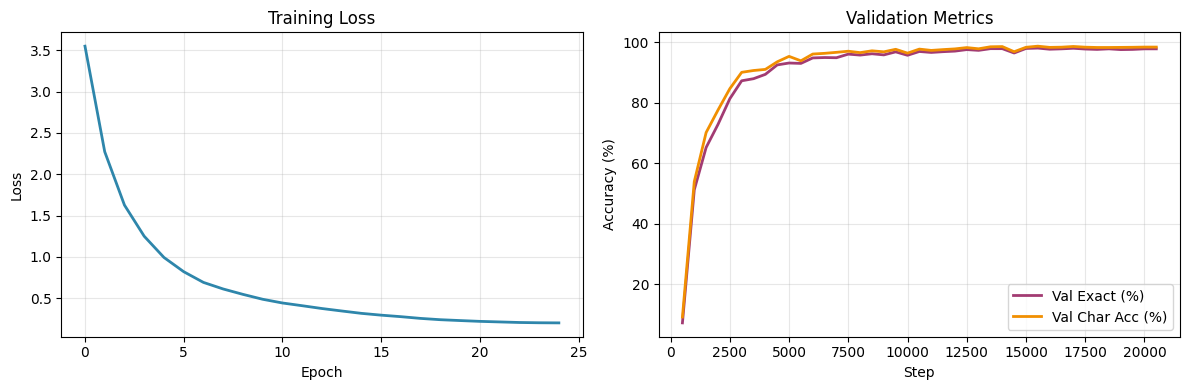

Saved: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\figures\task2_training_curves.png


In [19]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

if 'EXPR' not in globals():
    EXPR = Path('.').resolve() / 'expr'
if 'ROOT' not in globals():
    ROOT = Path('.').resolve()

hist_path = EXPR / 'train_history.json'
if not hist_path.exists():
    print('No train_history.json found. Run Step 4 (Train) first.')
else:
    hist = json.loads(hist_path.read_text(encoding='utf-8'))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(hist['epochs'], hist['loss'], color='#2E86AB', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(hist['steps'], hist['val_exact'], label='Val Exact (%)', color='#A23B72', linewidth=2)
    axes[1].plot(hist['steps'], hist['val_char_acc'], label='Val Char Acc (%)', color='#F18F01', linewidth=2)
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Validation Metrics')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    out_path = EXPR / 'figures' / 'task2_training_curves.png'
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=180, bbox_inches='tight')
    plt.show()
    print('Saved:', out_path)

## Step 5: Inference on train / val / test

In [21]:
def postprocess(s):
    return re.sub(r'\s+', ' ', s.strip())

def run_inference(image_paths, model, transform, converter, batch_size=32):
    model.eval()
    preds = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        tensors = [transform(Image.open(p).convert('L')) for p in batch_paths]
        batch = torch.stack(tensors).to(device)
        with torch.no_grad():
            logits = model(batch)
        T = logits.size(0)
        pred_flat = logits.argmax(dim=2).t().reshape(-1).cpu()
        lengths = torch.full((logits.size(1),), T, dtype=torch.int32)
        preds.extend(converter.decode(pred_flat, lengths))
    return [postprocess(p) for p in preds]

ckpt = torch.load(EXPR / 'best.pth', map_location=device)
model.load_state_dict(ckpt['state_dict'], strict=True)
transform = ResizeKeepRatioPad(IMG_H, IMG_W)

for name, gt_dir, out_file in [('train', DATA_TRAIN, EXPR/'predictions_train.txt'), ('val', DATA_VALID, EXPR/'predictions_val.txt'), ('test', DATA_TEST, EXPR/'predictions_test.txt')]:
    paths = sorted(gt_dir.glob('*.jpg'))
    if not paths:
        print(name, ': no images')
        continue
    preds = run_inference(paths, model, transform, converter)
    out_file.parent.mkdir(parents=True, exist_ok=True)
    out_file.write_text('\n'.join(preds), encoding='utf-8')
    print(name, ':', len(preds), '->', out_file)

C:\Users\AD\AppData\Local\Temp\ipykernel_20052\2107896090.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(EXPR / 'best.pth', map_location=device)


train : 26522 -> C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\predictions_train.txt
val : 9723 -> C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\predictions_val.txt
test : 5141 -> C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\predictions_test.txt


## Step 6: Evaluate by ICDAR OCR (exact match, Recall/Precision/Hmean)

In [22]:
def evaluate_icdar_ocr(pred_file, gt_dir):
    preds = [l.strip() for l in pred_file.read_text(encoding='utf-8', errors='replace').splitlines()]
    gt_paths = sorted(Path(gt_dir).glob('*.txt'))

    n_pair = min(len(preds), len(gt_paths))
    if len(preds) != len(gt_paths) and n_pair > 0:
        print(f'  (So sanh {n_pair} cap dau: pred={len(preds)} dong, gt={len(gt_paths)} file)')

    correct = 0
    total_gt = 0
    total_pred = 0
    for i in range(n_pair):
        gt_lines = [x.strip() for x in gt_paths[i].read_text(encoding='utf-8', errors='replace').splitlines()]
        pred_lines = [preds[i]]  # pred_file: 1 dong / anh

        total_gt += len(gt_lines)
        total_pred += len(pred_lines)
        for j in range(min(len(gt_lines), len(pred_lines))):
            if pred_lines[j].strip().lower() == gt_lines[j].strip().lower():
                correct += 1

    recall = (100.0 * correct / total_gt) if total_gt else 0.0
    precision = (100.0 * correct / total_pred) if total_pred else 0.0
    hmean = (2 * recall * precision / (recall + precision)) if (recall + precision) > 0 else 0.0

    return {
        'correct': correct,
        'total_gt': total_gt,
        'total_pred': total_pred,
        'recall': recall,
        'precision': precision,
        'hmean': hmean,
    }

for name, pred_f, gt_d in [('TRAIN', EXPR/'predictions_train.txt', DATA_TRAIN), ('VAL', EXPR/'predictions_val.txt', DATA_VALID), ('TEST', EXPR/'predictions_test.txt', DATA_TEST)]:
    if not pred_f.exists() or not gt_d.exists():
        continue
    r = evaluate_icdar_ocr(pred_f, gt_d)
    print('=' * 60)
    print(' ', name)
    print('=' * 60)
    print(f'  Correct (dong dung): {r["correct"]}')
    print(f'  Total GT lines:      {r["total_gt"]}')
    print(f'  Total Pred lines:    {r["total_pred"]}')
    print(f'  Recall:    {r["recall"]:.2f}%')
    print(f'  Precision: {r["precision"]:.2f}%')
    print(f'  Hmean:     {r["hmean"]:.2f}%')
    (EXPR / f'evaluation_result_{name.lower()}.txt').write_text(
        'ICDAR OCR evaluation (exact match, ignore case)\n'
        + f'Correct (dong dung): {r["correct"]}\n'
        + f'Total GT lines: {r["total_gt"]}\n'
        + f'Total Pred lines: {r["total_pred"]}\n'
        + f'Recall: {r["recall"]:.2f}%\n'
        + f'Precision: {r["precision"]:.2f}%\n'
        + f'Hmean: {r["hmean"]:.2f}%\n',
        encoding='utf-8'
    )
    print()

  TRAIN
  Correct (dong dung): 20518
  Total GT lines:      26522
  Total Pred lines:    26522
  Recall:    77.36%
  Precision: 77.36%
  Hmean:     77.36%

  VAL
  Correct (dong dung): 7311
  Total GT lines:      9723
  Total Pred lines:    9723
  Recall:    75.19%
  Precision: 75.19%
  Hmean:     75.19%

  TEST
  Correct (dong dung): 3769
  Total GT lines:      5141
  Total Pred lines:    5141
  Recall:    73.31%
  Precision: 73.31%
  Hmean:     73.31%



## Step 7: Visualize samples (GT vs Pred)

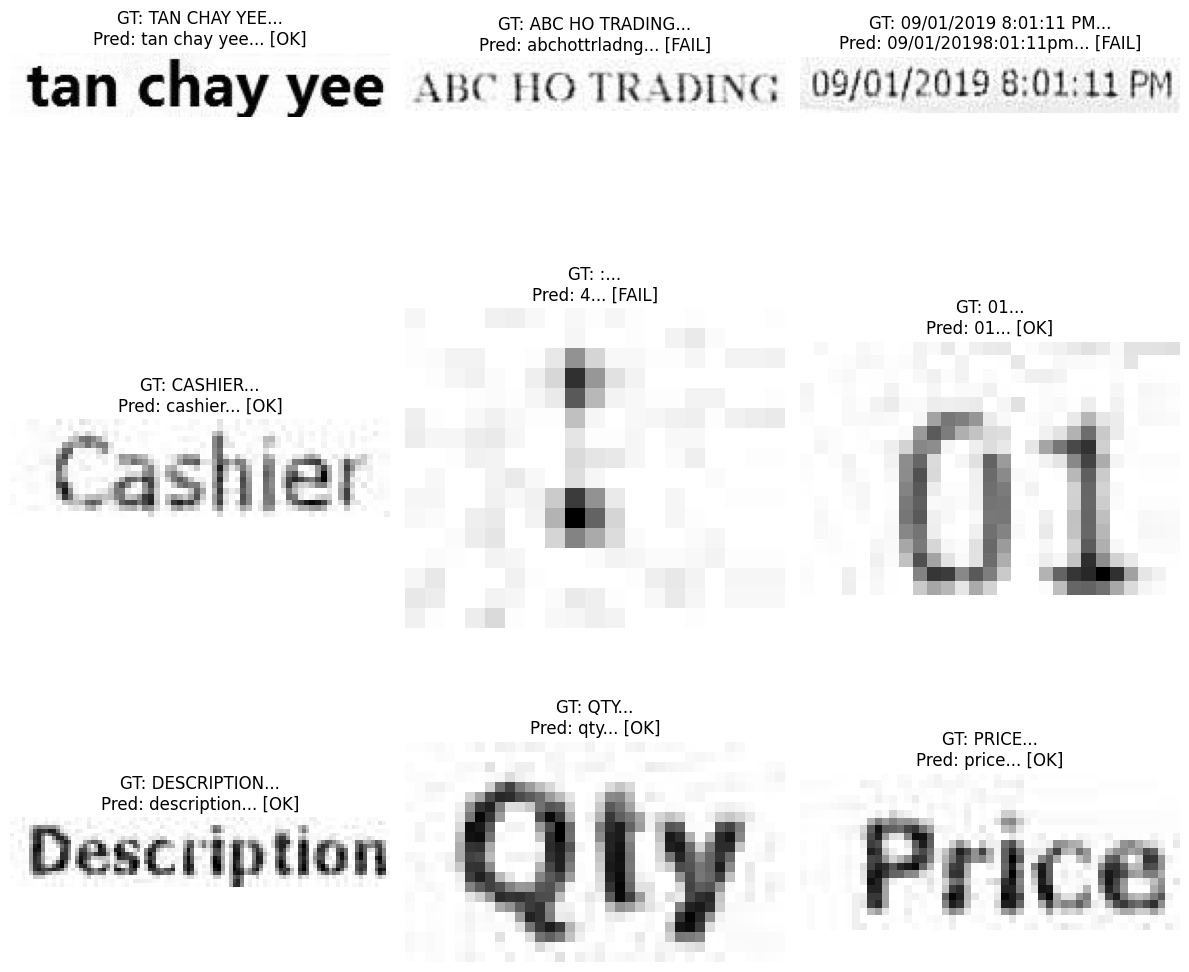

In [9]:
import matplotlib.pyplot as plt

paths = sorted(DATA_TEST.glob('*.jpg'))[:9]
if paths:
    preds = run_inference(paths, model, transform, converter)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i < len(paths):
            gt = (paths[i].with_suffix('.txt').read_text(encoding='utf-8').strip() if paths[i].with_suffix('.txt').exists() else '')
            pred = preds[i] if i < len(preds) else ''
            ok = 'OK' if gt.strip().lower() == pred.strip().lower() else 'FAIL'
            ax.imshow(Image.open(paths[i]).convert('L'), cmap='gray')
            ax.set_title(f'GT: {gt[:30]}...\nPred: {pred[:30]}... [{ok}]')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No test images found.')

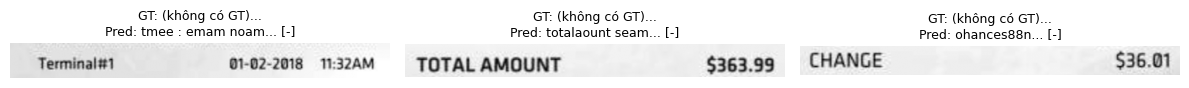

Tested 3 images from C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\demo_image


In [9]:
DEMO_DIR = ROOT / 'demo_image'
DEMO_DIR.mkdir(parents=True, exist_ok=True)
paths = sorted(DEMO_DIR.glob('*.jpg')) + sorted(DEMO_DIR.glob('*.png'))
paths = paths[:9]  # max 9 images
if paths:
    preds = run_inference(paths, model, transform, converter)
    import matplotlib.pyplot as plt
    n = len(paths)
    rows = (n + 2) // 3
    fig, axes = plt.subplots(max(1, rows), 3, figsize=(12, 4 * max(1, rows)))
    axes = np.array(axes).flatten()
    for i, ax in enumerate(axes):
        if i < n:
            gt_path = paths[i].with_suffix('.txt')
            gt = gt_path.read_text(encoding='utf-8').strip() if gt_path.exists() else '(no GT)'
            pred = preds[i] if i < len(preds) else ''
            ok = 'OK' if gt != '(no GT)' and gt.strip().lower() == pred.strip().lower() else ('-' if gt == '(no GT)' else 'FAIL')
            ax.imshow(Image.open(paths[i]).convert('L'), cmap='gray')
            ax.set_title(f'GT: {gt[:35]}...\nPred: {pred[:35]}... [{ok}]', fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f'Tested {len(paths)} images from {DEMO_DIR}')
else:
    print(f'No images in {DEMO_DIR}. Create folder and add .jpg/.png files to test.')

In [10]:
# Save model artifacts manually after training/inference
SAVE_DIR = EXPR
SAVE_DIR.mkdir(parents=True, exist_ok=True)

weights_path = SAVE_DIR / 'svtr_model_weights.pth'
ckpt_path = SAVE_DIR / 'svtr_model_checkpoint.pth'

torch.save(model.state_dict(), weights_path)
torch.save(
    {
        'state_dict': model.state_dict(),
        'alphabet': ALPHABET,
        'img_h': IMG_H,
        'img_w': IMG_W,
        'n_class': n_class,
    },
    ckpt_path,
)

print('Saved weights to:', weights_path)
print('Saved checkpoint to:', ckpt_path)

Saved weights to: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\svtr_model_weights.pth
Saved checkpoint to: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\svtr_model_checkpoint.pth


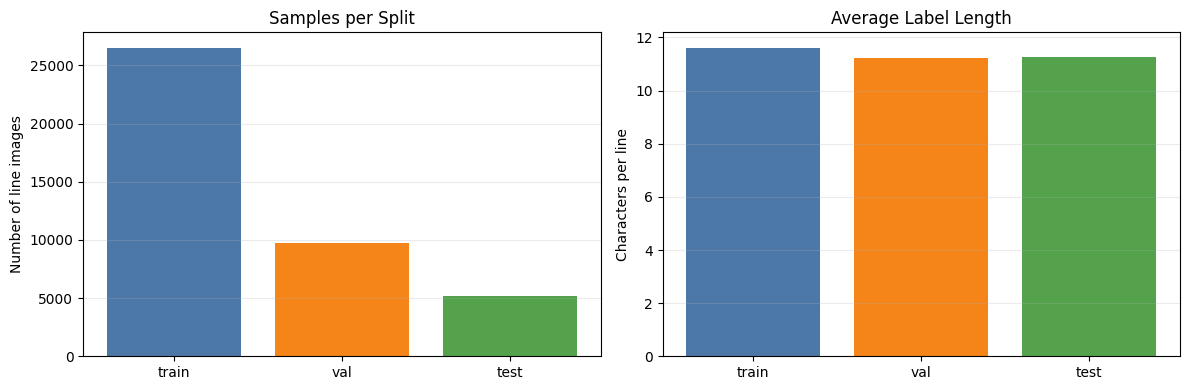

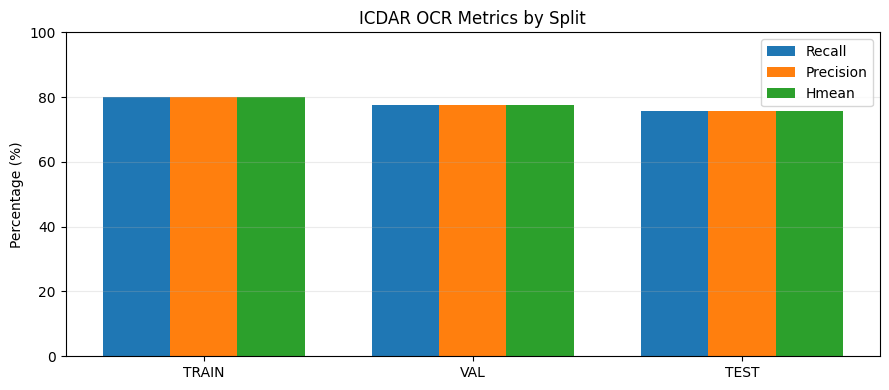

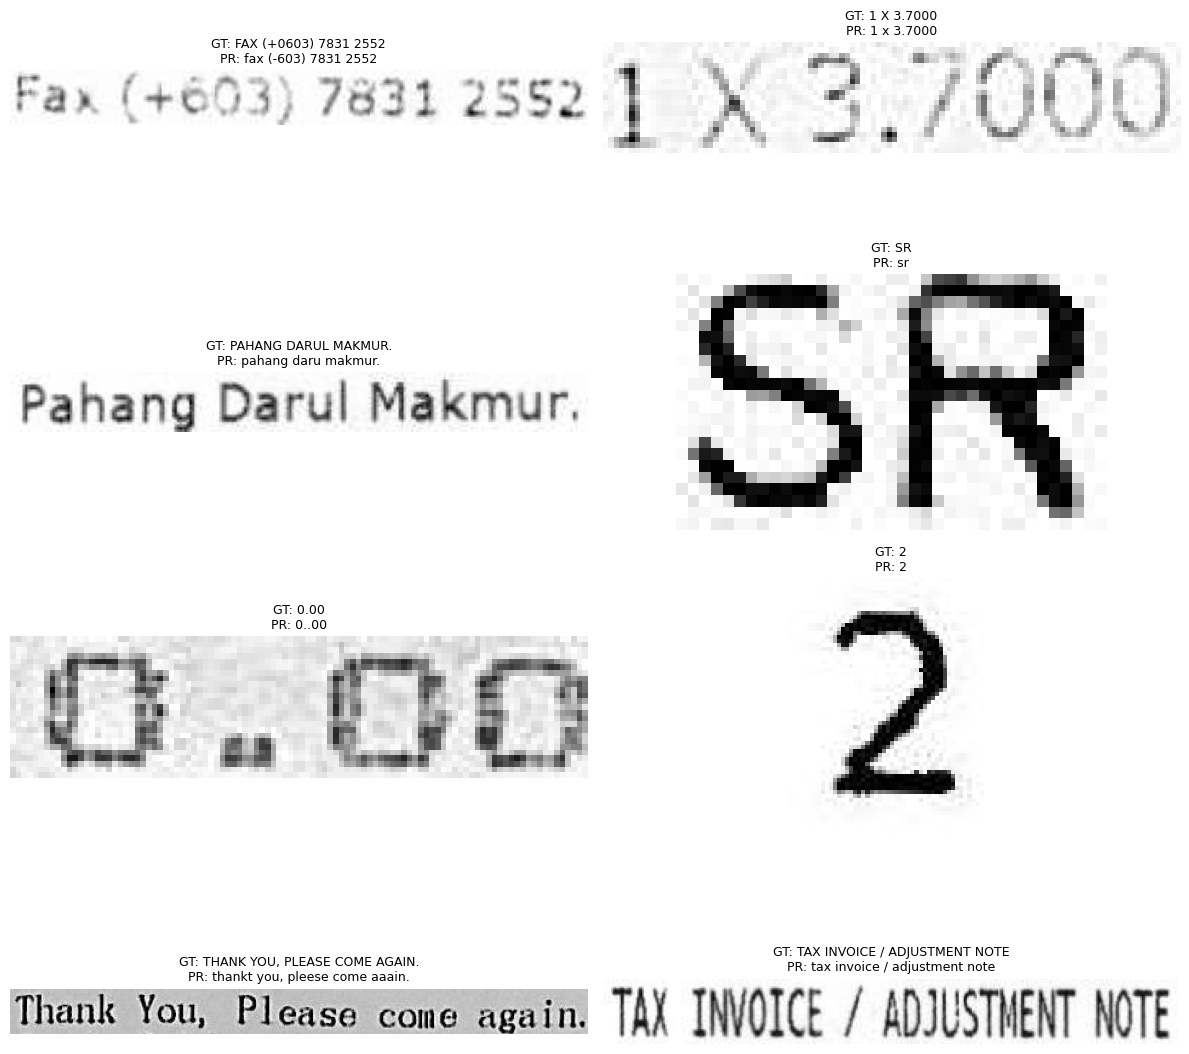

Saved: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\figures\task2_dataset_overview.png
Saved: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\figures\task2_metrics_overview.png
Saved: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\figures\task2_qualitative_examples.png
Saved: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\task2_eval_table.tex
Saved: C:\Users\AD\Downloads\ComputerVision\Project_Final\My_Project\task2_svtr_v1\expr\task2_results_summary.txt
TRAIN | samples=26522 | avg_len=11.61 | R=80.16% P=80.16% H=80.16%
  VAL | samples= 9723 | avg_len=11.24 | R=77.62% P=77.62% H=77.62%
 TEST | samples= 5141 | avg_len=11.27 | R=75.76% P=75.76% H=75.76%


In [10]:
import random
import matplotlib.pyplot as plt
from textwrap import shorten

# Self-contained fallback for paths
if 'ROOT' not in globals():
    ROOT = Path('.').resolve()
if 'EXPR' not in globals():
    EXPR = ROOT / 'expr'
if 'DATA_TRAIN' not in globals():
    BASE = ROOT.parent / 'task2_upgrade_v2'
    if (BASE / 'data_train').exists():
        DATA_TRAIN, DATA_VALID, DATA_TEST = BASE/'data_train', BASE/'data_valid', BASE/'data_test'
    else:
        DATA_TRAIN, DATA_VALID, DATA_TEST = ROOT/'data_train', ROOT/'data_valid', ROOT/'data_test'

FIG_DIR = EXPR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

def parse_eval_file(path):
    out = {'correct': 0, 'total_gt': 0, 'total_pred': 0, 'recall': 0.0, 'precision': 0.0, 'hmean': 0.0}
    if not path.exists():
        return out
    for line in path.read_text(encoding='utf-8', errors='replace').splitlines():
        s = line.strip().lower()
        if s.startswith('correct:'):
            out['correct'] = int(line.split(':', 1)[1].strip())
        elif s.startswith('total gt lines:'):
            out['total_gt'] = int(line.split(':', 1)[1].strip())
        elif s.startswith('total pred lines:'):
            out['total_pred'] = int(line.split(':', 1)[1].strip())
        elif s.startswith('recall:'):
            out['recall'] = float(line.split(':', 1)[1].replace('%', '').strip())
        elif s.startswith('precision:'):
            out['precision'] = float(line.split(':', 1)[1].replace('%', '').strip())
        elif s.startswith('hmean:'):
            out['hmean'] = float(line.split(':', 1)[1].replace('%', '').strip())
    return out

def split_stats(data_dir):
    txts = sorted(Path(data_dir).glob('*.txt'))
    lengths = []
    for p in txts:
        try:
            lengths.append(len(p.read_text(encoding='utf-8', errors='replace').strip()))
        except Exception:
            pass
    n = len(lengths)
    return {
        'n_samples': n,
        'avg_len': float(np.mean(lengths)) if n else 0.0,
        'max_len': int(np.max(lengths)) if n else 0,
        'min_len': int(np.min(lengths)) if n else 0,
    }

# 1) Load quantitative results
splits = ['train', 'val', 'test']
metrics = {s: parse_eval_file(EXPR / f'evaluation_result_{s}.txt') for s in splits}
stats = {
    'train': split_stats(DATA_TRAIN),
    'val': split_stats(DATA_VALID),
    'test': split_stats(DATA_TEST),
}

# 2) Dataset overview chart
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(splits, [stats[s]['n_samples'] for s in splits], color=['#4c78a8', '#f58518', '#54a24b'])
axes[0].set_title('Samples per Split')
axes[0].set_ylabel('Number of line images')
axes[0].grid(axis='y', alpha=0.25)

axes[1].bar(splits, [stats[s]['avg_len'] for s in splits], color=['#4c78a8', '#f58518', '#54a24b'])
axes[1].set_title('Average Label Length')
axes[1].set_ylabel('Characters per line')
axes[1].grid(axis='y', alpha=0.25)

plt.tight_layout()
fig_dataset = FIG_DIR / 'task2_dataset_overview.png'
plt.savefig(fig_dataset, dpi=180, bbox_inches='tight')
plt.show()

# 3) Metrics overview chart (ICDAR exact match)
fig, ax = plt.subplots(figsize=(9, 4))
x = np.arange(len(splits))
width = 0.25
ax.bar(x - width, [metrics[s]['recall'] for s in splits], width, label='Recall')
ax.bar(x, [metrics[s]['precision'] for s in splits], width, label='Precision')
ax.bar(x + width, [metrics[s]['hmean'] for s in splits], width, label='Hmean')
ax.set_xticks(x)
ax.set_xticklabels([s.upper() for s in splits])
ax.set_ylabel('Percentage (%)')
ax.set_title('ICDAR OCR Metrics by Split')
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', alpha=0.25)
plt.tight_layout()
fig_metrics = FIG_DIR / 'task2_metrics_overview.png'
plt.savefig(fig_metrics, dpi=180, bbox_inches='tight')
plt.show()

# 4) Qualitative examples on TEST
pred_path = EXPR / 'predictions_test.txt'
test_imgs = sorted(DATA_TEST.glob('*.jpg'))
gt_map = {p.stem: p for p in DATA_TEST.glob('*.txt')}
preds = pred_path.read_text(encoding='utf-8', errors='replace').splitlines() if pred_path.exists() else []

pairs = []
for i, img_path in enumerate(test_imgs):
    gt_path = gt_map.get(img_path.stem)
    if not gt_path:
        continue
    gt = gt_path.read_text(encoding='utf-8', errors='replace').strip()
    pred = preds[i].strip() if i < len(preds) else ''
    pairs.append((img_path, gt, pred))

if pairs:
    sample = random.sample(pairs, min(8, len(pairs)))
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    axes = axes.flatten()
    for ax, (img_path, gt, pred) in zip(axes, sample):
        img = Image.open(img_path).convert('L')
        ax.imshow(np.array(img), cmap='gray')
        ax.set_title('GT: ' + shorten(gt, width=40, placeholder='...') + '\nPR: ' + shorten(pred, width=40, placeholder='...'), fontsize=9)
        ax.axis('off')
    for j in range(len(sample), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    fig_qual = FIG_DIR / 'task2_qualitative_examples.png'
    plt.savefig(fig_qual, dpi=180, bbox_inches='tight')
    plt.show()
else:
    fig_qual = None
    print('No test pairs found for qualitative figure.')

# 5) Export LaTeX table + text summary
table_tex = EXPR / 'task2_eval_table.tex'
table_tex.write_text(
    '\\begin{table}[H]\n'
    '\\centering\n'
    '\\caption{ICDAR-style OCR results (exact line match, case-insensitive).}\n'
    '\\begin{tabular}{lrrrrrr}\n'
    '\\toprule\n'
    'Split & Correct & GT Lines & Pred Lines & Recall (\\%) & Precision (\\%) & Hmean (\\%) \\\\n'
    '\\midrule\n'
    + '\n'.join([
        f"{s.upper()} & {metrics[s]['correct']} & {metrics[s]['total_gt']} & {metrics[s]['total_pred']} & {metrics[s]['recall']:.2f} & {metrics[s]['precision']:.2f} & {metrics[s]['hmean']:.2f} \\\\" for s in splits
    ]) + '\n'
    '\\bottomrule\n'
    '\\end{tabular}\n'
    '\\end{table}\n',
    encoding='utf-8'
)

summary_txt = EXPR / 'task2_results_summary.txt'
summary_txt.write_text(
    'Task2 OCR Result Summary\n'
    + '=' * 60 + '\n'
    + '\n'.join([
        f"{s.upper()}: samples={stats[s]['n_samples']}, avg_len={stats[s]['avg_len']:.2f}, recall={metrics[s]['recall']:.2f}%, precision={metrics[s]['precision']:.2f}%, hmean={metrics[s]['hmean']:.2f}%" for s in splits
    ]) + '\n',
    encoding='utf-8'
)

print('Saved:', fig_dataset)
print('Saved:', fig_metrics)
print('Saved:', fig_qual if fig_qual else 'No qualitative figure')
print('Saved:', table_tex)
print('Saved:', summary_txt)

for s in splits:
    print(f"{s.upper():>5} | samples={stats[s]['n_samples']:>5} | avg_len={stats[s]['avg_len']:.2f} | R={metrics[s]['recall']:.2f}% P={metrics[s]['precision']:.2f}% H={metrics[s]['hmean']:.2f}%")